
# **Assignment 2 - Convolutional Autoencoders**
Vico Gianluca - i6183186 <br>
Gianzina Alexandra - i6294354

In [ ]:
import keras
import numpy as np
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

epochs=40

## Loading the dataset

We load the dataset and split it in 80% for training, 10% for validation and 10% for testing.

Moreover, we normalize the data, such that the range of each channel of the image is [0, 1] instead of [0, 255].

In [ ]:
(x_train, _), (x_test, _) = cifar10.load_data()
x = np.vstack([x_train, x_test])

x= x.astype(float) /255.0

x_train, x_temp = train_test_split( x, test_size=0.2, random_state=42)

x_val, x_test = train_test_split( x_temp, test_size=0.5, random_state=42)

Now we have a look to some images from the dataset

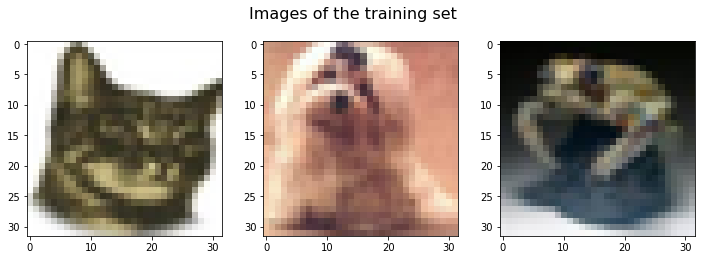

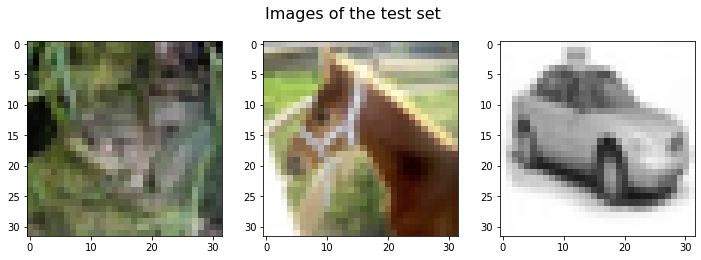

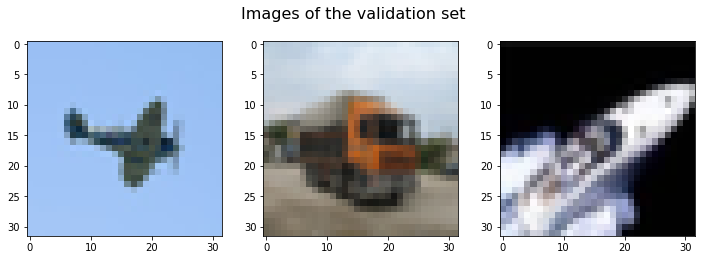

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.tight_layout()
fig.suptitle("Images of the training set", fontsize=16)
for i in range(3):
    ax[i].imshow(x_train[i])
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.tight_layout()
fig.suptitle("Images of the test set", fontsize=16)
for i in range(3):
    ax[i].imshow(x_test[i])
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.tight_layout()
fig.suptitle("Images of the validation set", fontsize=16)
for i in range(3):
    ax[i].imshow(x_val[i])
plt.show()

The images are 32x32, so low resolution. Most of the them have colors, but there are some images that are mostly black & white. So, the model will be trained mostly on colored images.

##Implementing the autoencoder 

The model is defined as described in the assignment.

We use the ReLU function as activation function. In this way we prevent gradient vanishing, but the model might generate images with values greater than 1, which can cause invalid colors.

In [ ]:
activation_funct = "relu" # or sigmoid
loss_funct = "mean_squared_error" # or binary_crossentropy
opt = tf.keras.optimizers.Adam()  # for some reason the keras.optimizers does not define Adam

model = Sequential()

# Encoder
model.add(Conv2D(8, (3, 3),padding="same",activation=activation_funct,strides=1, input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

model.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))
model.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3),padding="same",activation=activation_funct,strides=1))

# Decoder
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))
model.add(UpSampling2D(size=(2, 2)))

model.add(Conv2D(3, (3, 3),padding="same",activation=activation_funct,strides=1))

model.compile(loss=loss_funct,
              optimizer=opt)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          1744      
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 16)       0

We can compute the size of the last convolutional layer of the encoder.

The kernel size K is 3; the channels C are 16; the input size is 8x8, so W is 8; the stride S is 1; the padding P is 1.

$(\dfrac{W - K + 2p}{S} + 1)^2 C = (\dfrac{8-3+2\cdot 1}{1}+1)^2 \cdot 16 = 1024$.

The input space of the model is $W^2C = 32^2 \cdot 3 = 3072$. This means that the encoder comprimes the figure by a factor of 3. 

### Model training

In [ ]:
history =model.fit(x_train,x_train, batch_size=32, epochs=epochs,validation_data=(x_val,x_val))

Epoch 1/40
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0120 - val_loss: 0.0066
Epoch 2/40
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 3/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 4/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/40
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 6/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 9/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 10/40
1500/1500 [==============================] - 11s 8ms/step - l

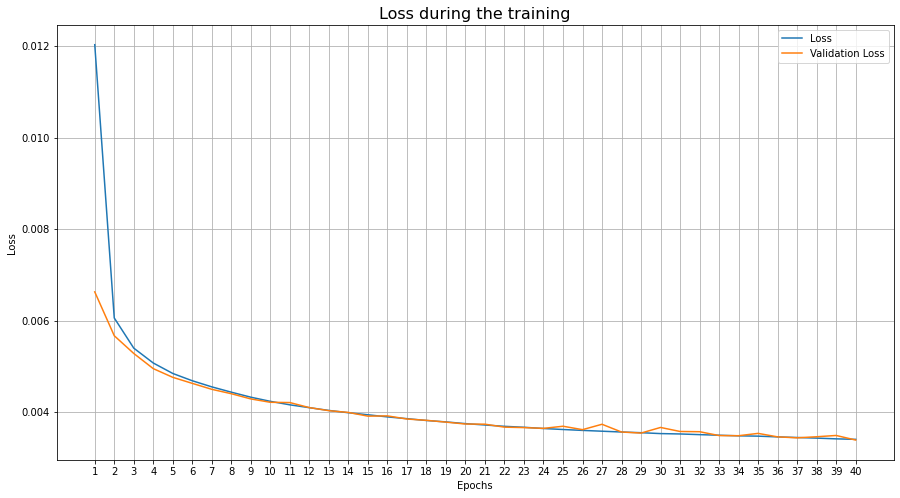

In [ ]:
epoch_list= [i+1 for i in range(epochs)]
plt.figure(figsize=(15,8))
plt.plot(epoch_list,history.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.title("Loss during the training", fontsize=16)
plt.plot(epoch_list,history.history["val_loss"],label="Validation Loss")
plt.legend()

plt.xticks(epoch_list)
plt.grid()
plt.show()

In [ ]:
history2 =model.evaluate(x_test,x_test, batch_size=32)

188/188 [==============================] - 1s 5ms/step - loss: 0.0034


The model is trained for 40 epochs and, as we can see, the loss value is decreasing to 0.0032 and the validation loss is also decreasing. The loss in the test set is the same with the loss in the training set.

The model is not overfitting yet, since both the training and the validation loss seem to be still decreasing. So, it is possible to improve the performance of the model by training it further.

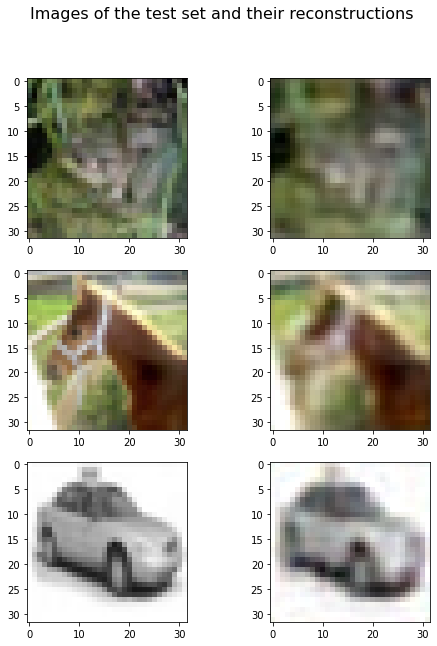

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
fig.suptitle("Images of the test set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i, 0].imshow(x_test[i])
    output= model.predict(x_test[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i, 1].imshow(output)
plt.show()

After applying the autoencoder we can see that the result pictures are quite blurry but we can still recognize the content of the image.

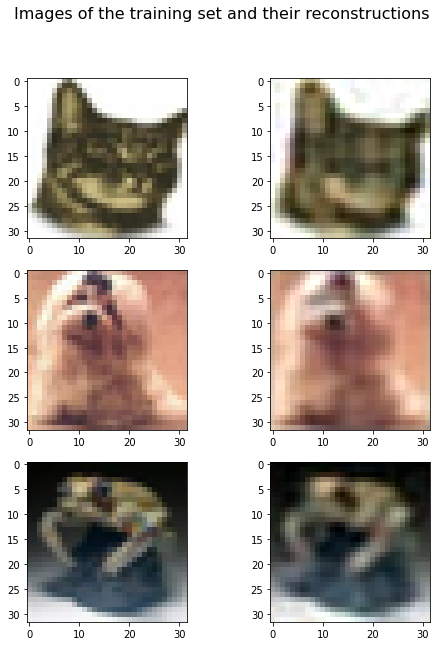

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

fig.suptitle("Images of the training set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i, 0].imshow(x_train[i])
    output= model.predict(x_train[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i, 1].imshow(output)
plt.show()

By inspecting some images from the test set and train set, we try to observe whether there is a noticeable difference between the reconstruction of the images used for training and those used only for testing. We can see that the pictures from the training set have better outcome because the model was trained on them and already knew them

## Implementing a smaller Autoencoder with less layers

We are implementing a smaller network. It is similar to the previous one, but we are removing the middle layer. 

In this way, there are less parameters to train and a larger latent space. So, the images are less compressed by the encoder and we expect a smaller error when decoding the images.

In [ ]:
activation_funct = "relu" # or sigmoid
loss_funct = "mean_squared_error" # or binary_crossentropy
opt = tf.keras.optimizers.Adam()  # for some reason the keras.optimizers does not define Adam

model2 = Sequential()
#Encoder
model2.add(Conv2D(8, (3, 3),padding="same",activation=activation_funct,strides=1, input_shape=x_train.shape[1:]))
model2.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

model2.add(Conv2D(16, (3, 3),padding="same",activation=activation_funct,strides=1))

#Decoder
model2.add(UpSampling2D(size=(2, 2)))

model2.add(Conv2D(3, (3, 3),padding="same",activation=activation_funct,strides=1))

model2.compile(loss=loss_funct,
              optimizer=opt)

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 3)         435       
                                                                 
Total params: 1,827
Trainable params: 1,827
Non-traina

We can compute the size of the last convolutional layer of the encoder.

The kernel size K is 3; the channels C are 16; the input size is 16x16, so W is 16; the stride S is 1; the padding P is 1.

$(\dfrac{W - K + 2p}{S} + 1)^2 C = (\dfrac{16-3+2\cdot 1}{1}+1)^2 \cdot 16 = 4096$.

The size of the latent space is 4 times the one of the previous model. The input size is still 3072. In this model the latent space is larger than the input, so the encoder does not compress the image. It instead projects it 

In [ ]:
history_m2 =model2.fit(x_train,x_train, batch_size=32, epochs=epochs,validation_data=(x_val,x_val))

Epoch 1/40
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 2/40
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 3/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/40
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/40
1500/1500 [==============================] - 11s 7ms/step - l

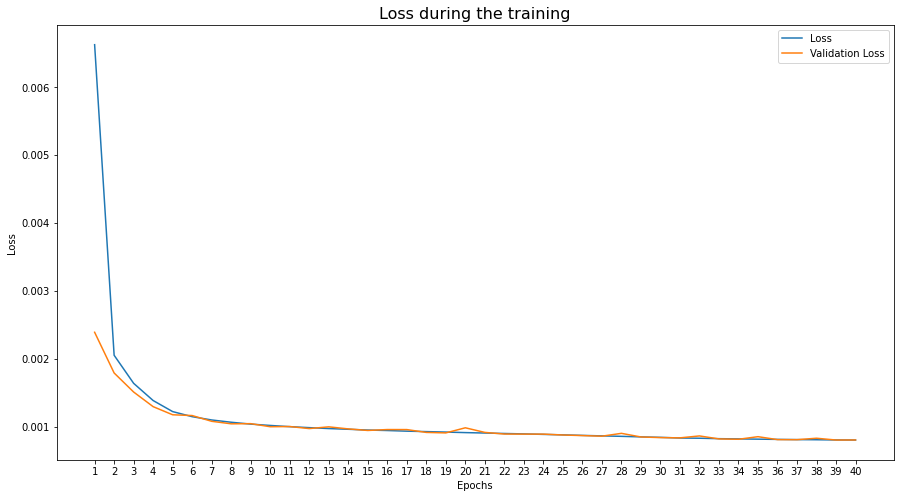

In [ ]:
epoch_list= [i+1 for i in range(epochs)]
plt.figure(figsize=(15,8))
plt.plot(epoch_list,history_m2.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.title("Loss during the training", fontsize=16)
plt.plot(epoch_list,history_m2.history["val_loss"],label="Validation Loss")
plt.legend()

plt.xticks(epoch_list)

plt.show()

In [ ]:
history_2__m2 =model2.evaluate(x_test,x_test, batch_size=32)

188/188 [==============================] - 1s 5ms/step - loss: 7.9275e-04


The model is trained for 40 epochs and as we can see the loss value is decreasing to 8.2220e-04 and the validation loss is also decreasing. The loss in the test set is almost the same with the loss in the training set. As before, the model is not overfitting yet

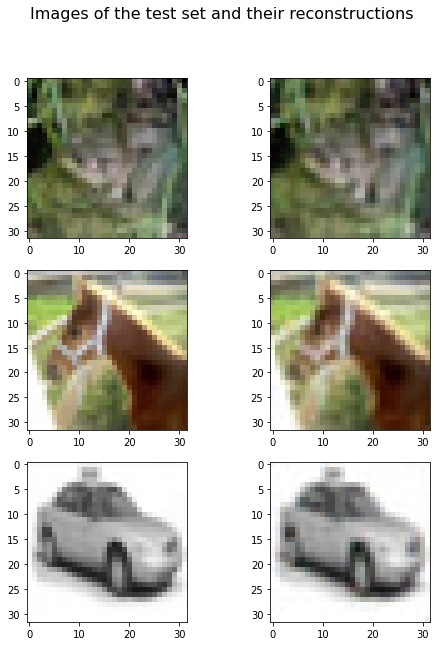

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

fig.suptitle("Images of the test set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i,0].imshow(x_test[i])
    output= model2.predict(x_test[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i,1].imshow(output)
plt.show()

The images reconstructed are better (less blurry) than in the previous model because we have a larger latent space. However, they are not identical to the original (e.g., the horse losses an eye).

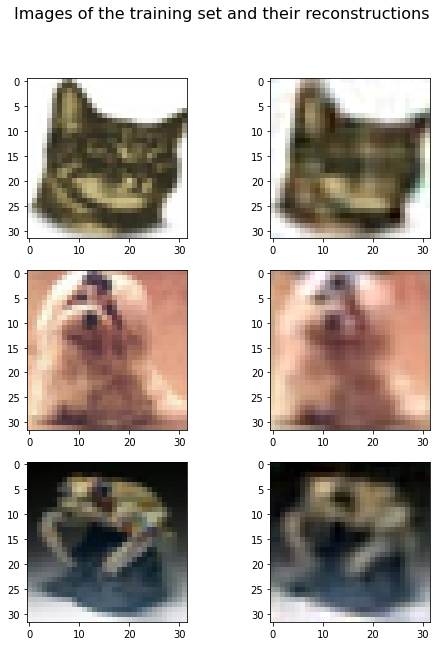

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
# fig.tight_layout()
fig.suptitle("Images of the training set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i,0].imshow(x_train[i])
    output= model.predict(x_train[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i,1].imshow(output)
plt.show()

The pictures above give better results, as the model has been trained on these images. The quality of these pictures is similar to the test sets.

## Implementing an Autoencoder with smaller latent space

If we add an extra layer in the encoder and we downsample the size further, we obtain a deeper model with a smaller latent space.


In [ ]:
activation_funct = "relu" # or sigmoid
loss_funct = "mean_squared_error" # or binary_crossentropy
opt = tf.keras.optimizers.Adam()  # for some reason the keras.optimizers does not define Adam

model3 = Sequential()

model3.add(Conv2D(8, (3, 3),padding="same",activation=activation_funct,strides=1, input_shape=x_train.shape[1:]))
model3.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

model3.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))
model3.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

model3.add(Conv2D(16, (3, 3),padding="same",activation=activation_funct,strides=1))


model3.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))
model3.add(Conv2D(16, (3, 3),padding="same",activation=activation_funct,strides=1))
model3.add(UpSampling2D(size=(2, 2)))
model3.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))


model3.add(UpSampling2D(size=(2, 2)))
model3.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))
model3.add(UpSampling2D(size=(2, 2)))

model3.add(Conv2D(3, (3, 3),padding="same",activation=activation_funct,strides=1))

model3.compile(loss=loss_funct,
              optimizer=opt)

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          1744      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

We can compute the size of the last convolutional layer of the encoder.

The kernel size K is 3; the channels C are 16; the input size is 4x4, so W is 4; the stride S is 1; the padding P is 1.

$(\dfrac{W - K + 2p}{S} + 1)^2 C = (\dfrac{4-3+2\cdot 1}{1}+1)^2 \cdot 16 = 256$.

The size of the latent space is 16 times smaller than the one of the previous model with size 4096. The input size is 3072. 
We can see that in this model the latent space is very small in comparison to the input, so the encoder compresses the input image 0,083 times.

In [ ]:
history_m3 =model3.fit(x_train,x_train, batch_size=32, epochs=epochs,validation_data=(x_val,x_val))

Epoch 1/40
1500/1500 [==============================] - 43s 9ms/step - loss: 0.0197 - val_loss: 0.0139
Epoch 2/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 3/40
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 4/40
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 5/40
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 6/40
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 7/40
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 8/40
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 9/40
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 10/40
1500/1500 [==============================] - 13s 9ms/step - l

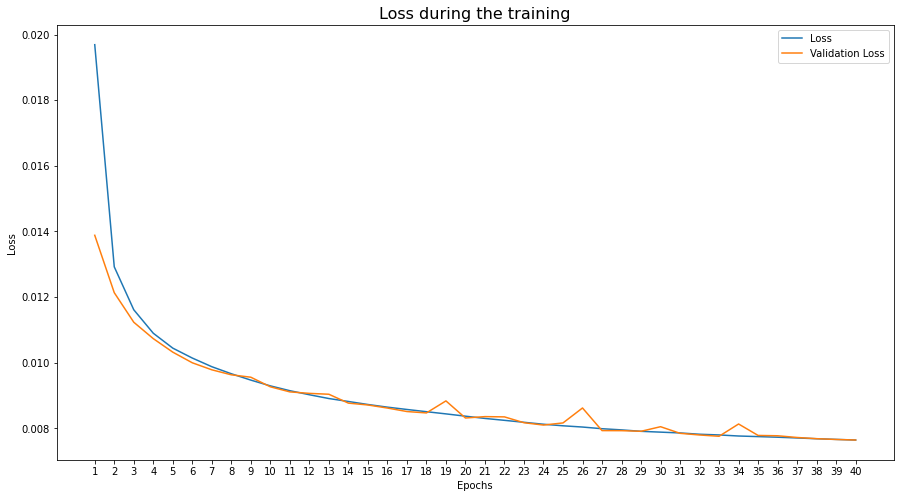

In [ ]:
epoch_list= [i+1 for i in range(epochs)]
plt.figure(figsize=(15,8))
plt.plot(epoch_list,history_m3.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.title("Loss during the training", fontsize=16)
plt.plot(epoch_list,history_m3.history["val_loss"],label="Validation Loss")
plt.legend()

plt.xticks(epoch_list)

plt.show()

In [ ]:
history_3__m3 =model3.evaluate(x_test,x_test, batch_size=32)

188/188 [==============================] - 1s 5ms/step - loss: 0.0077


The loss value is decreacing and during the last epoch is 0.0077. It is the same for both the validation loss and test loss. From the graph we can see that we are not overfitting and if we do more epochs we could decrease the loss even more.

If we compare this graph with the previous ones, we can see that the loss in this graph is decreasing slower. This is due to the larger number of parameters to train.

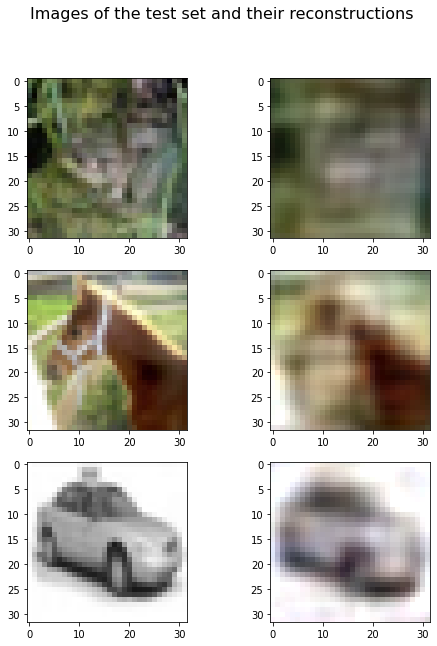

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

fig.suptitle("Images of the test set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i, 0].imshow(x_test[i])
    output= model3.predict(x_test[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i, 1].imshow(output)
plt.show()

The image quality in these reconstructed test pictures is more blurry than the first model. The latent space is smaller, so it makes sense that the output quality is not impoved.

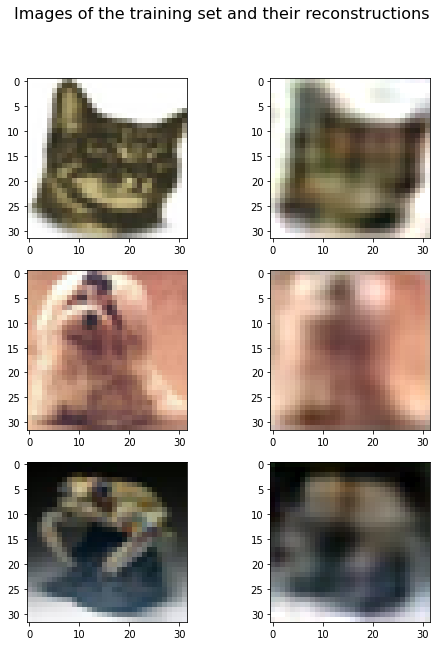

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))

fig.suptitle("Images of the training set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i, 0].imshow(x_train[i])
    output= model3.predict(x_train[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i, 1].imshow(output)
plt.show()

In comparison to the training pictures, the reconstructed pictures we get from testing look equally blurry. The model is not overfitting on the training images.

We can observe that when we have less latent space the reconstructed images become more blurred due to the increased loss value.

##Colorization

First, we try to reuse the previous model on images without colors.

This model takes as input images with 3 channels, but BW images has only 1 channel, so we duplicate this channel to make 3-channel images.

The model is trained to reconstruct the input image, but not to colorize the input. However, the training set contains mostly colored images, so we might expect colored outputs.<br>

<br>During the convertion from RGB to gray we followed the method mentioned in the following website. https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cv2.cvtColor

In [ ]:
def convert_to_gray_3D(matrix):
    gray= np.dot(matrix,[0.299,0.587,0.114]).reshape(-1,32,32,1)

    return np.broadcast_to(gray, (gray.shape[0],32,32,3))

gray_test = convert_to_gray_3D(x_test)

In [ ]:
history_gray =model.evaluate(gray_test,x_test, batch_size=32)

188/188 [==============================] - 1s 5ms/step - loss: 0.0095


The loss value here is a bit higher than the previous ones. We assume that this happens because changing the colour of the images to gray scale, might reduce the vibrancy of the images leading to the loss increase

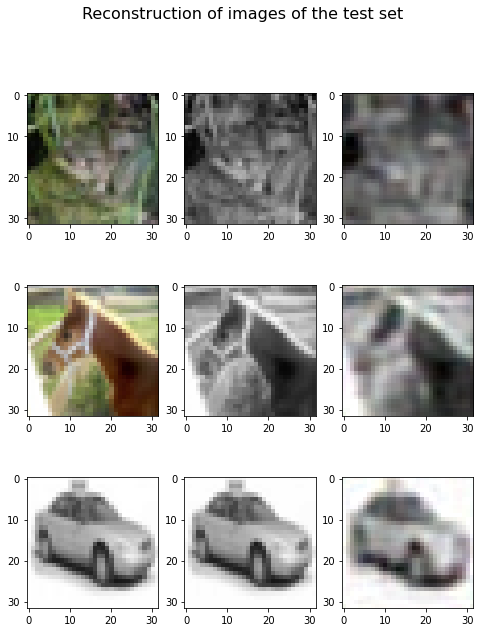

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(8, 10))

fig.suptitle("Reconstruction of images of the test set", fontsize=16)
for i in range(3):
    ax[i, 0].imshow(x_test[i])
    ax[i, 1].imshow(gray_test[i])
    output= model.predict(gray_test[i].reshape(1,32,32,3)).reshape(32,32,3)
    output=np.clip(output, 0,1)
    ax[i, 2].imshow(output)
plt.show()

The first column contains the original images; the second column contains the BW version of the images; the third columns is the output of the model.

As we can see, the reconstruted image is not BW, so the model is somehow adding the color. However, it does not perform well in the colorization task.

### New model for grayscale

Now we train a model similar to the one for the first part of the assignment to colorize images.

The input is a BW 32x32 images and the output is the color of that image.

Instead of the RGB color space, we use YCrCb (a.k.a. YUV). Y is the luminance and we use this value as input. The model has to learn the Cr and Cb values. Therefore, the output of the network is a 32x32x2 matrix.

Then, the given Y and the predicted Cr and Cb are converted back to the RGB color space in order to visualize the colorized image.<br>

<br>During the convertion from RBG to YCrCb we followed the methods mentioned in the following website. https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cv2.cvtColor

In [ ]:
def compute_chrominance(matrix):
  grayscale = np.dot(matrix,[0.299,0.587,0.114]).reshape(-1,32,32,1)
  cr= (matrix[:,:,:,0].reshape(-1,32,32,1)-grayscale) * 0.713 + 0.5
  cb = (matrix[:,:,:,1].reshape(-1,32,32,1)-grayscale) * 0.564 + 0.5
  return grayscale,np.concatenate([cr,cb],3)


def to_rgb(grayscale, chrominance):
  red = grayscale + 1.403 * (chrominance[:,:,:,0]-0.5).reshape(-1,32,32,1)
  green = grayscale - 0.714 *(chrominance[:,:,:,0]-0.5).reshape(-1,32,32,1) - 0.344 *(chrominance[:,:,:,1]-0.5).reshape(-1,32,32,1)
  blue =grayscale + 1.773 * (chrominance[:,:,:,1]-0.5).reshape(-1,32,32,1)
  return np.concatenate([red,green,blue],3)


In [ ]:
gr_x_train,cr_x_train = compute_chrominance(x_train)

gr_x_test,cr_x_test = compute_chrominance(x_test)

gr_x_val,cr_x_val = compute_chrominance(x_val)


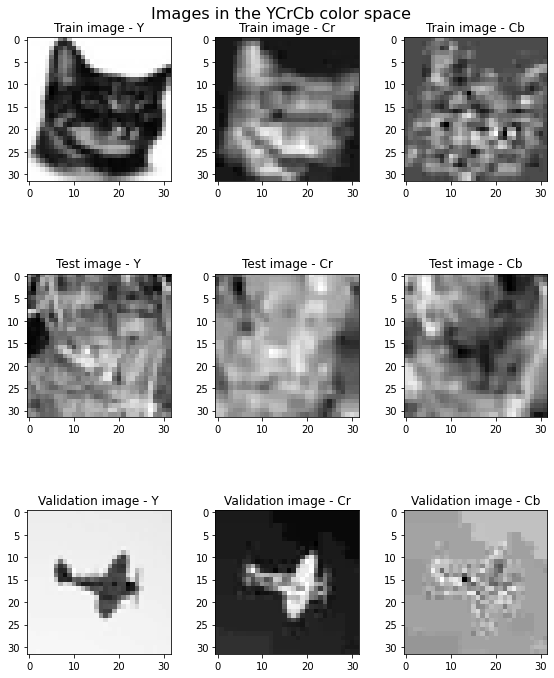

In [ ]:

fig, ax = plt.subplots(3, 3, figsize=(8, 10))
fig.tight_layout()
fig.suptitle("Images in the YCrCb color space", fontsize=16)
ax[0,0].set_title("Train image - Y")
ax[0,0].imshow(gr_x_train[0].reshape(32,32),cmap="gray")
ax[0,1].set_title("Train image - Cr")
ax[0,1].imshow(cr_x_train[0,:,:,0],cmap="gray")
ax[0,2].set_title("Train image - Cb")
ax[0,2].imshow(cr_x_train[0,:,:,1],cmap="gray")

ax[1,0].set_title("Test image - Y")
ax[1,0].imshow(gr_x_test[0].reshape(32,32),cmap="gray")
ax[1,1].set_title("Test image - Cr")
ax[1,1].imshow(cr_x_test[0,:,:,0],cmap="gray")
ax[1,2].set_title("Test image - Cb")
ax[1,2].imshow(cr_x_test[0,:,:,1],cmap="gray")

ax[2,0].set_title("Validation image - Y")
ax[2,0].imshow(gr_x_val[0].reshape(32,32),cmap="gray")
ax[2,1].set_title("Validation image - Cr")
ax[2,1].imshow(cr_x_val[0,:,:,0],cmap="gray")
ax[2,2].set_title("Validation image - Cb")
ax[2,2].imshow(cr_x_val[0,:,:,1],cmap="gray")
plt.show()

These are the three channels used in this colorization task. Y is usd as input, while the other two are the exprected outputs.

In [ ]:
activation_funct = "relu" # or sigmoid
loss_funct = "mean_squared_error" # or binary_crossentropy
opt = tf.keras.optimizers.Adam()  # for some reason the keras.optimizers does not define Adam

colorizer = Sequential()

# Encoder
colorizer.add(Conv2D(8, (3, 3),padding="same",activation=activation_funct,strides=1, input_shape=gr_x_train.shape[1:]))
colorizer.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

colorizer.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))
colorizer.add(MaxPooling2D(strides=(2,2), padding="same", pool_size=(2, 2)))

colorizer.add(Conv2D(16, (3, 3),padding="same",activation=activation_funct,strides=1))

# Decoder
colorizer.add(UpSampling2D(size=(2, 2)))
colorizer.add(Conv2D(12, (3, 3),padding="same",activation=activation_funct,strides=1))
colorizer.add(UpSampling2D(size=(2, 2)))

colorizer.add(Conv2D(2, (3, 3),padding="same",activation=activation_funct,strides=1))   # 2 filters instead of 3 -> only 2 channels

colorizer.compile(loss=loss_funct,
              optimizer=opt)


The model is similar to the model from the first task. The only changes are the input size (1 channel vs 3 channels) and the number of filters in the last layer (2 instead of 3).

In [ ]:
colorizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          1744      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 16, 16, 16)      

We can also compute the size of the last convolutional layer of the encoder for the colorizer.

The kernel size K is 3; the channels C are 16; the input size is 8x8, so W is 8; the stride S is 1; the padding P is 1.

$(\dfrac{W - K + 2p}{S} + 1)^2 C = (\dfrac{8-3+2\cdot 1}{1}+1)^2 \cdot 16 = 1024$.

We can see that the size of the latent space is the same as the input size. So we expect that the reconstructed pictures will not be more or less blurry.

In [ ]:
history_colorization =colorizer.fit(gr_x_train,cr_x_train, batch_size=32, epochs=epochs,validation_data=(gr_x_val,cr_x_val))


Epoch 1/40
1500/1500 [==============================] - 13s 7ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 2/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/40
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/40
1500/1500 [==============================] - 11s 7ms/step - l

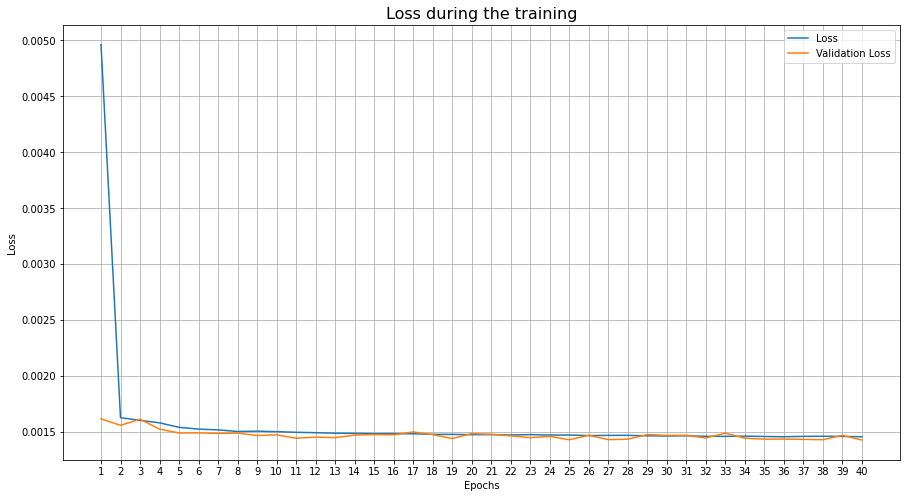

In [ ]:

epoch_list_colorization= [i+1 for i in range(epochs)]
plt.figure(figsize=(15,8))
plt.plot(epoch_list_colorization,history_colorization.history["loss"],label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.title("Loss during the training", fontsize=16)
plt.plot(epoch_list_colorization,history_colorization.history["val_loss"],label="Validation Loss")
plt.legend()

plt.xticks(epoch_list_colorization)
plt.grid()
plt.show()

In [ ]:
history_colorization2 = colorizer.evaluate(gr_x_test,cr_x_test, batch_size=32)

188/188 [==============================] - 1s 5ms/step - loss: 0.0014


After 5 epocs the training loss stops decreasing. The validation loos and the test loss have values similar to the training loss. This may be because of the model being too small for this task or because a small latent space.

Note that we cannot compare this loss values with the loss values from the previous models because the outputs of the models are different.

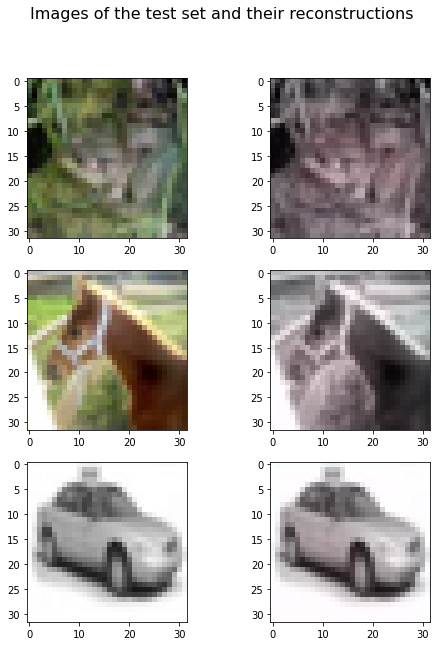

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
# fig.tight_layout()
fig.suptitle("Images of the test set and their reconstructions", fontsize=16)
for i in range(3):
    ax[i, 0].imshow(x_test[i])
    output = colorizer.predict(gr_x_test[i].reshape(1,32,32,1)).reshape(1,32,32,2)
    
    output = to_rgb(gr_x_test[i], output).reshape(32,32,3)
    output = np.clip(output, 0,1)
    ax[i, 1].imshow(output)
plt.show()

The model procuses images with some colors, however the are not vibrant as the original images.

Most colors are a kind of brown, but in the second image the model is generating some green